**Francis O'Hara**

Fall 2024

CS 251: Data Analysis and Visualization

# Project 7: Radial Basis Function Neural Networks

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.core.pylabtools import figsize

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

## Task 1: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 1a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalize each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [3]:
train = pd.read_csv("data/rbf_dev_train.csv")
test = pd.read_csv("data/rbf_dev_test.csv")

rbf_dev_train = train.copy()[["X", "Y"]].to_numpy()
rbf_dev_test = test.copy()[["X", "Y"]].to_numpy()
y_train = train.copy()["class"].to_numpy()
y_test = test.copy()["class"].to_numpy()

In [4]:
# define methods for processing train and test datasets
def normalize(data, mins, maxs):
    """Min-Max normalizes each feature in `data`.

    Parameters
    ----------
    data : np.ndarray; shape=(num_samples, num_features)
        The numpy array whose features are to be normalized.
    mins : np.ndarray; shape=(num_features,)
        The minimum values to be used for normalizing each feature.
    maxs : np.ndarray; shape=(num_features,)
        The maximum values to be used for normalizing each feature.

    Returns
    -------
    normalized_data : np.ndarray; shape=(num_samples, num_features)
        The min-max normalized numpy array.
    """
    return (data - mins)/(maxs - mins)

In [5]:
# preprocess train and test sets
mins = rbf_dev_train.min(axis=0)
maxs = rbf_dev_train.max(axis=0)

rbf_dev_train = normalize(rbf_dev_train, mins, maxs)
rbf_dev_test = normalize(rbf_dev_test, mins, maxs)

#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [6]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [7]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


##### Check dtypes (detailed)

In [8]:
print(f'Your training set is an float? {isinstance(rbf_dev_train[0,0], float)}')
print(f'Your training classes is an int? {isinstance(y_train[0], np.int64)}')
print(f'Your test set is an float? {isinstance(rbf_dev_test[0,0], float)}')
print(f'Your test classes is an int? {isinstance(y_test[0], np.int64)}')

Your training set is an float? True
Your training classes is an int? True
Your test set is an float? True
Your test classes is an int? True


##### Check normalization (detailed)

In [9]:
print(f'Your training set mins/maxs: {rbf_dev_train.min(axis=0)}/{rbf_dev_train.max(axis=0)}\nand should be                [0. 0.]/[1. 1.]')
print(f'Your test set mins/maxs: {rbf_dev_test.min(axis=0)}/{rbf_dev_test.max(axis=0)}\nand should be            [0.02038 0.01194]/[0.99805 0.98749]')

print(f'Training values look ok? {len(np.unique(rbf_dev_train)) > 2}')
print(f'Test values look ok? {len(np.unique(rbf_dev_test)) > 2}')

Your training set mins/maxs: [0. 0.]/[1. 1.]
and should be                [0. 0.]/[1. 1.]
Your test set mins/maxs: [0.02038 0.01194]/[0.99805 0.98749]
and should be            [0.02038 0.01194]/[0.99805 0.98749]
Training values look ok? True
Test values look ok? True


### 1b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

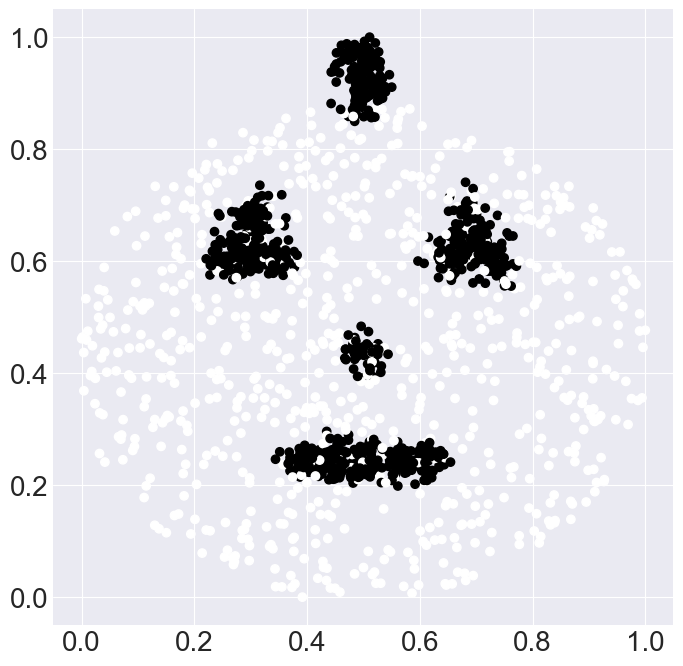

In [10]:
# plot training data
plt.figure(figsize=(8, 8))
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train)
plt.show()

## Task 2: Radial basis function neural network

In [11]:
from rbf_net import RBF_Net

### 2a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [12]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [13]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [14]:
np.random.seed(0)
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

In [15]:
np.random.seed(0)

C:\Users\franc\AppData\Local\Temp\ipykernel_1420\3075388902.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


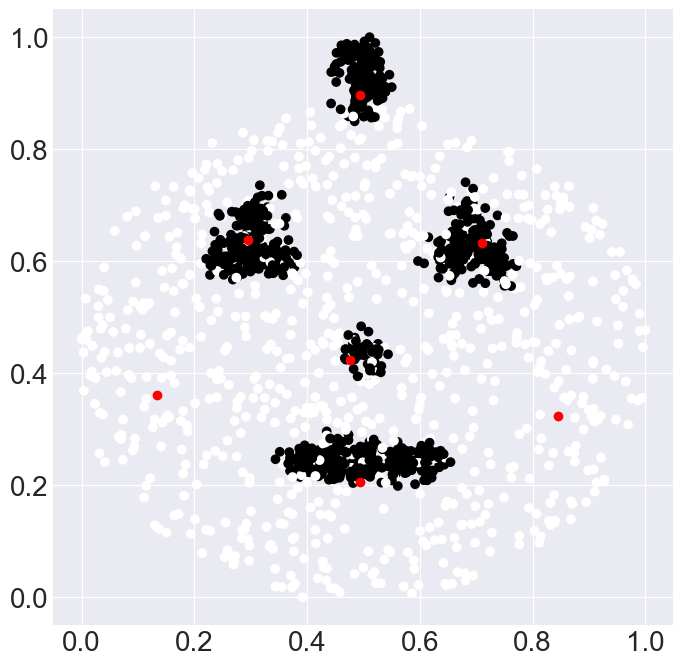

In [16]:
# initialize RBFNet
rbf_net = RBF_Net(7, 2)
rbf_net.initialize(rbf_dev_train)

# plot training data with prototypes
plt.figure(figsize=(8, 8))
plt.scatter(rbf_dev_train[:, 0], rbf_dev_train[:, 1], c=y_train)
plt.scatter(rbf_net.get_prototypes()[:, 0], rbf_net.get_prototypes()[:, 1], c="red")
plt.legend()
plt.show()

**Question 1:** Do you think the prototypes enable the RBF network to learn the data well? Why or why not?

**Answer 1:**  
Yes, the prototypes do enable the RBF network to learn the data well because a majority of the points within the radius of influence of each prototype belong to a single class. This means each prototype will send a strong signal to particular output classes to which most points close to the prototype belong to, and this is the desired behavior of the prototypes.

### 2b. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [17]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [18]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.72136  0.61505 -0.20481]\n [-0.72151  0.61487 -0.20466]\n [-0.72144  0.61479 -0.20465]]')

Your output layer activation is
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]

and should be
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]


### 2c. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code from the linear regression project involving `scipy.linalg.lstsq()`.

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

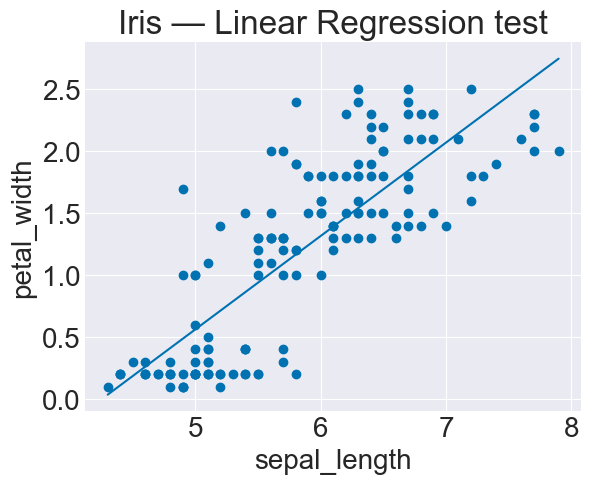

In [19]:
df = pd.read_csv('https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 2d. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.
- `accuracy`: Compute the accuracy by comparing the network predicted and actual class for each data sample.



In [20]:
net = RBF_Net(10, 2)
net.train(rbf_dev_train, y_train)

In [21]:
y_pred_train = net.predict(rbf_dev_train)
accuracy_train = net.accuracy(y_train, y_pred_train)
print(f"Train Accuracy: {accuracy_train:.2f}")

Train Accuracy: 0.89


In [22]:
y_pred_test = net.predict(rbf_dev_test)
accuracy_test = net.accuracy(y_test, y_pred_test)
print(f"Test Accuracy: {accuracy_test}")

Test Accuracy: 0.9125


## Task 3: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 3a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

In [23]:
x_train = np.load("data/mnist_train_data.npy")
y_train = np.load("data/mnist_train_labels.npy")
x_test = np.load("data/mnist_test_data.npy")
y_test = np.load("data/mnist_test_labels.npy")

In [24]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


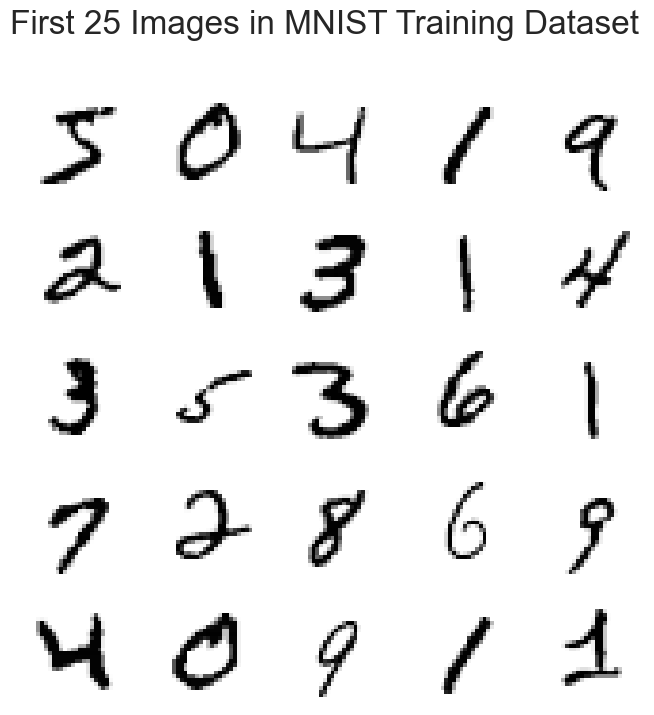

In [25]:
fig, axs = plt.subplots(5, 5)

for i in range(5):
    for j in range(5):
        axs[i, j].imshow(x_train[(i*5) + j])
        axs[i, j].set_xticks([], [])
        axs[i, j].set_yticks([], [])


fig.set_figheight(8)
fig.set_figwidth(8)
plt.suptitle("First 25 Images in MNIST Training Dataset")
plt.show()

### 3b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [26]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))
print(f"{x_train.shape = }")
print(f"{x_test.shape = }")

x_train.shape = (60000, 784)
x_test.shape = (10000, 784)


In [27]:
x_train = x_train / 255
x_test = x_test / 255
print(f"x_train min: {x_train.min()}")
print(f"x_train max: {x_train.max()}")
print(f"x_test min: {x_test.min()}")
print(f"x_test max: {x_test.max()}")

x_train min: 0.0
x_train max: 1.0
x_test min: 0.0
x_test max: 1.0


### 3c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~1500) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [28]:
mnist_net = RBF_Net(150, 10)
x_train_mini = x_train[:2000]
y_train_mini = y_train[:2000]
mnist_net.initialize(x_train_mini)
mnist_net.train(x_train_mini, y_train_mini)

y_pred_train = mnist_net.predict(x_train_mini)
accuracy_train = mnist_net.accuracy(y_pred_train, y_train_mini)

y_pred_test = mnist_net.predict(x_test)
accuracy_test = mnist_net.accuracy(y_pred_test, y_test)

print(f"Train accuracy: {accuracy_train}")
print(f"Test accuracy: {accuracy_test}")

Train accuracy: 0.9415
Test accuracy: 0.9098


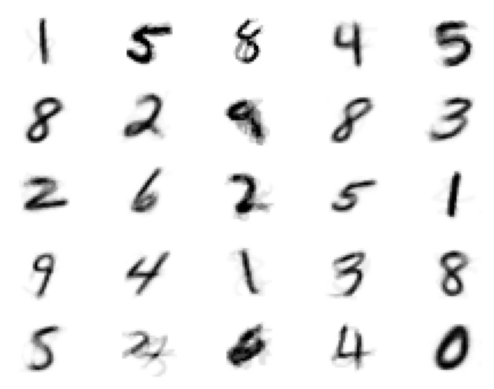

In [29]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

**Question 2:** Which part of the training process takes the longest?

**Answer 2:**
Performing K-means clustering to obtain the hidden units and their corresponding sigmas is the longest part of the training process.

**Question 3:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Answer 3:**
I achieved an accuracy of 93.7% on the training set with 2000 training samples and 150 hidden units.


**Question 4:** Using the same fit parameters that you used to compute the answer to Question 3, what test accuracy did you achieve?

**Answer 4:**
I achieved an accuracy of 90.8% on the testing set, using the same parameters used for prediction with the training set above.

## Extensions

### a. Reminder: AI Policy

The goal of extensions is to learn and create something new beyond the base project that excites you. To serve this goal and out of fairness to your hardworking classmates, **generative AI (e.g. ChatGPT, Copilot, etc.) is strongly discouraged.** If you do use it, you should use it either at the micro scale (e.g. to better understand syntax of a particular command) or at the outline level (e.g. to get a basic idea).

### b. Guidelines

To receive credit for any extension, you must:
1. Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
2. **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
3. Include (*labeled!*) plots and/or numbers to present your results.
4. Write up your extensions below or in a separate notebook.
5. Give kudos to all sources, including anyone that you consulted.

### c. Suggestions

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

The ideas below are **suggested** extensions — feel free to go in another direction related to this project that is not listed!

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

### 2) Visualize network predictions

Make visualizations to show and interpret the MNIST network predictions. Lots of possibilities, here are a few specific ideas:
- Make show a grid of test samples labeled with their predicted digit.
- Analyze if the network performance favors accuracy for certain digits and not others.
- Are errors on certain classes correlated in any way? Does it depend on their digit similarity (e.g. 1 looks like a 7, but not a 0).
- Make and interpret a confusion plot.

### 3) Explore parameter space

When training your RBF network on MNIST, you had to pick some parameter values to use by hand. Pick one or more parameters and systematically vary them to quantify their effect on accuracy and simulation time.

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

### 5) Other datasets

Use your RBF network to classify other datasets.

### 6) Analyze the trained network

Run simulations then analyze and interpret the results. Here are some ideas:
- Visualize and analyze how the prototypes influence the classification results.
- Visualize and analyze how the network weights influence the classification results.

### 7) Confusion matrix

Make and interpret a confusion matrix.

### 8) Compare to your other supervised learning algorithms

Compare runtime and accuracy with your KNN and/or Naive Bayes classifiers.

My Extensions
I decided to implement the following extensions:
1. Improve performance on MNIST with PCA.
2. Visualize network predictions.
3. Explore parameter space (num_hidden_units, no bias node?).
4. Make and interpret a confusion matrix.


## Extension 1) Improve performance on MNIST with PCA
For this extension, PCA will be used to reduce the dimensions of both the training and the testing datasets before training the RBFNet and making predictions.
The time it takes to compute with the original dataset will be tracked and compared with the time it takes to compute with the PCA-reduced dataset.
 - The RBFNet will be trained on only 5000 samples of the original training dataset and the PCA-reduced training dataset due to the sheer size of the dataset and how computationally intensive training is.
 - The RBFNet will then make predictions for the same 5000 samples of the original training dataset and the same 5000 samples of the PCA-reduced training dataset.
 - The RBFNet will make predictions for all 10000 samples of the original testing dataset and all 10000 samples of the PCA-reduced testing dataset.

In [30]:
from pca import PCA

# reload the MNIST dataset
x_train = np.load("data/mnist_train_data.npy")
y_train = np.load("data/mnist_train_labels.npy")
x_test = np.load("data/mnist_test_data.npy")
y_test = np.load("data/mnist_test_labels.npy")

# reshape the data
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1] * x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1] * x_test.shape[2]))
print(f"{x_train.shape = }")
print(f"{x_test.shape = }")

# convert to pandas dataframes for pca
x_train_df = pd.DataFrame(x_train)
x_test_df = pd.DataFrame(x_test)

x_train.shape = (60000, 784)
x_test.shape = (10000, 784)


**NB:** The implementation of the `pca.fit()` method was modified so that if `normalize_dataset` is set to `True`, we only divide each cell by 255 since each feature represents a pixel value and will have the same max and min.

In [31]:
# perform PCA
mnist_pca_train = PCA(x_train_df)
mnist_pca_test = PCA(x_test_df)

start = time.time()
mnist_pca_train.fit(x_train_df.columns, True)
pca_train_time = time.time() - start

start = time.time()
mnist_pca_test.fit(x_test_df.columns, True)
pca_test_time = time.time() - start

print(f"It took {pca_train_time:0.2f} seconds to perform PCA on the training data.")
print(f"It took {pca_test_time:0.2f} seconds to perform PCA on the testing data.")

It took 2.12 seconds to perform PCA on the training data.
It took 0.74 seconds to perform PCA on the testing data.


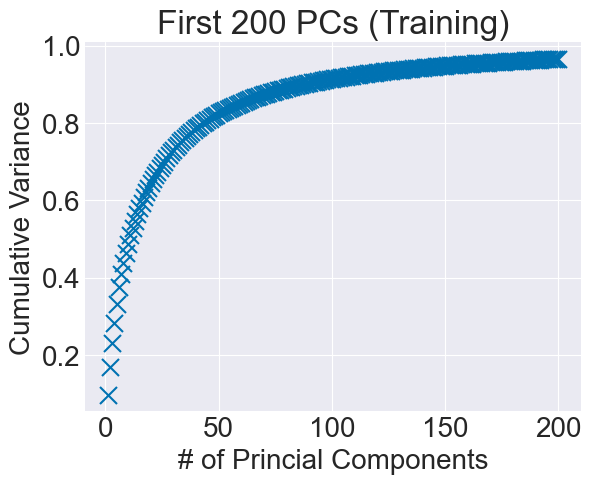

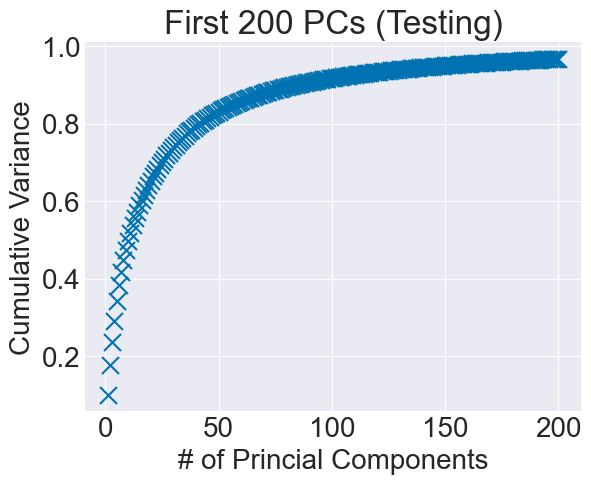

In [32]:
# plot elbowplot to select principal components to keep
mnist_pca_train.elbow_plot(200, "Training")
plt.show()

mnist_pca_test.elbow_plot(200, "Testing")
plt.show()

Based on the elbow plots above, keeping the first 150 principal components will retain over 90% of the variation in the data in both the training and testing datasets.
The code cell below confirms the exact proportions:

In [33]:
print(f"Percentage of variation captured by first 150 PCs in training data: {mnist_pca_train.get_cum_var()[150] * 100:0.2f}")
print(f"Percentage of variation captured by first 150 PCs in testing data: {mnist_pca_test.get_cum_var()[150] * 100:0.2f}")

Percentage of variation captured by first 150 PCs in training data: 94.88
Percentage of variation captured by first 150 PCs in testing data: 95.12


Hence, keeping the first 150 principal components will specifically capture about 94% of the variation in the training dataset and about 95% of the variation in the testing dataset.
The code cell below projects both datasets into the PCA space using only the first 150 principal components.

In [34]:
x_train_reduced = mnist_pca_train.pca_project(range(150))
x_test_reduced = mnist_pca_test.pca_project(range(150))
print(f"{x_train_reduced.shape = }")
print(f"{x_test_reduced.shape = }")

x_train_reduced.shape = (60000, 150)
x_test_reduced.shape = (10000, 150)


Hence, the reduced training and testing datasets have 150 features instead of the original 784 features, but are still able to retain most (about 94%) of the variation in their original datasets.
The code cells below will train an RBF net on the original dataset and reduced dataset and record the duration of each:

Training time for original dataset: 2246.4302184581757 seconds.
Training time for reduced dataset: 168.89162039756775 seconds.


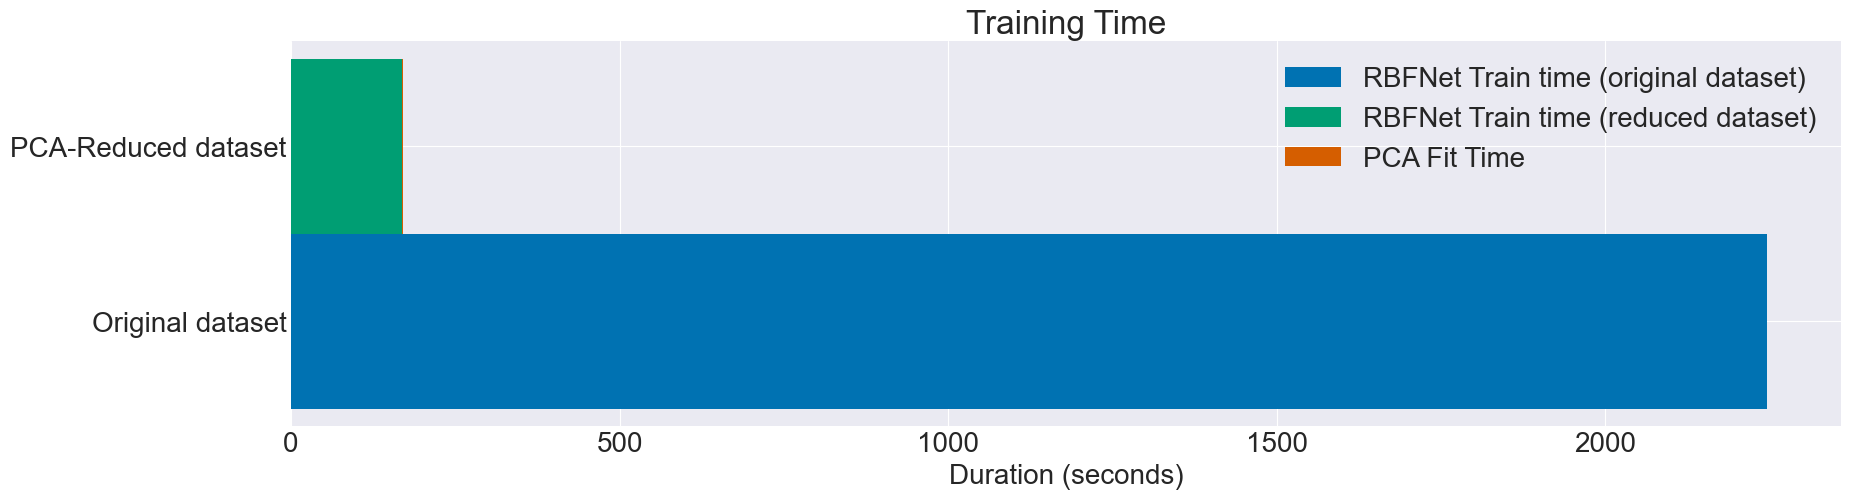

In [85]:
mnist_net_original = RBF_Net(150, 10)
start_time = time.time()
mnist_net_original.initialize(x_train[:5000])
mnist_net_original.train(x_train[:5000], y_train[:5000])
fit_time_original = time.time() - start_time

mnist_net_reduced = RBF_Net(150, 10)
start_time = time.time()
mnist_net_reduced.initialize(x_train_reduced[:5000])
mnist_net_reduced.train(x_train_reduced[:5000], y_train[:5000])
fit_time_reduced = time.time() - start_time

print(f"Training time for original dataset: {fit_time_original} seconds.")
print(f"Training time for reduced dataset: {fit_time_reduced} seconds.")


# visualize results
plt.figure(figsize=(20, 5))

bar_width = 0.3
plt.barh((0,), (fit_time_original,), bar_width, label="RBFNet Train time (original dataset)")
plt.barh((0 + bar_width,), (fit_time_reduced,), bar_width, label="RBFNet Train time (reduced dataset)")
plt.barh(y=(0 + bar_width,), width=(pca_train_time,), height=bar_width, left=(fit_time_reduced,), label="PCA Fit Time")
plt.yticks((0, 0 + bar_width), ("Original dataset", "PCA-Reduced dataset"))
plt.xlabel("Duration (seconds)")
plt.title("Training Time")
plt.legend()
plt.show()

As can be seen above, reducing the dimensions of the training dataset with PCA resulted in a decrease in the amount of time it takes to train the RBFNet by about a factor of 13.
The amount of time it took to perform PCA is also a very tiny fraction of the time it took to train the RBFNet on the full dataset as it is only a tiny sliver on the bar graph.
These results are generally expected as PCA is not as computationally expensive as algorithms such as K-Means clustering and training on fewer features is expected to result in a shorter training time.

These results however haven't told us anything about the accuracy of the trained model.

Next, the trained RBF nets will be used to make predictions for the original training and testing dataset and then for the PCA-reduced training and testing datasets and the resulting accuracies and durations shall be recorded for each.

Prediction time of RBF Net trained on original-sized training dataset for original-sized training dataset: 13.495059490203857 seconds
Accuracy of RBF Net trained on original-sized training dataset for original-sized training dataset: 93.98 %
Prediction time of RBF Net trained on original-sized training dataset for original-sized testing dataset: 26.453740119934082 seconds
Accuracy of RBF Net trained on original-sized training dataset for original-sized testing dataset: 92.48 %
Prediction time of RBF Net trained on PCA-reduced training dataset for PCA-reduced training dataset: 7.893054485321045 seconds
Accuracy of RBF Net trained on PCA-reduced training dataset for PCA-reduced training dataset: 93.62 %
Prediction time of RBF Net trained on PCA-reduced training dataset for PCA-reduced testing dataset: 20.035994052886963 seconds
Accuracy of RBF Net trained on PCA-reduced training dataset for PCA-reduced testing dataset: 10.45 %


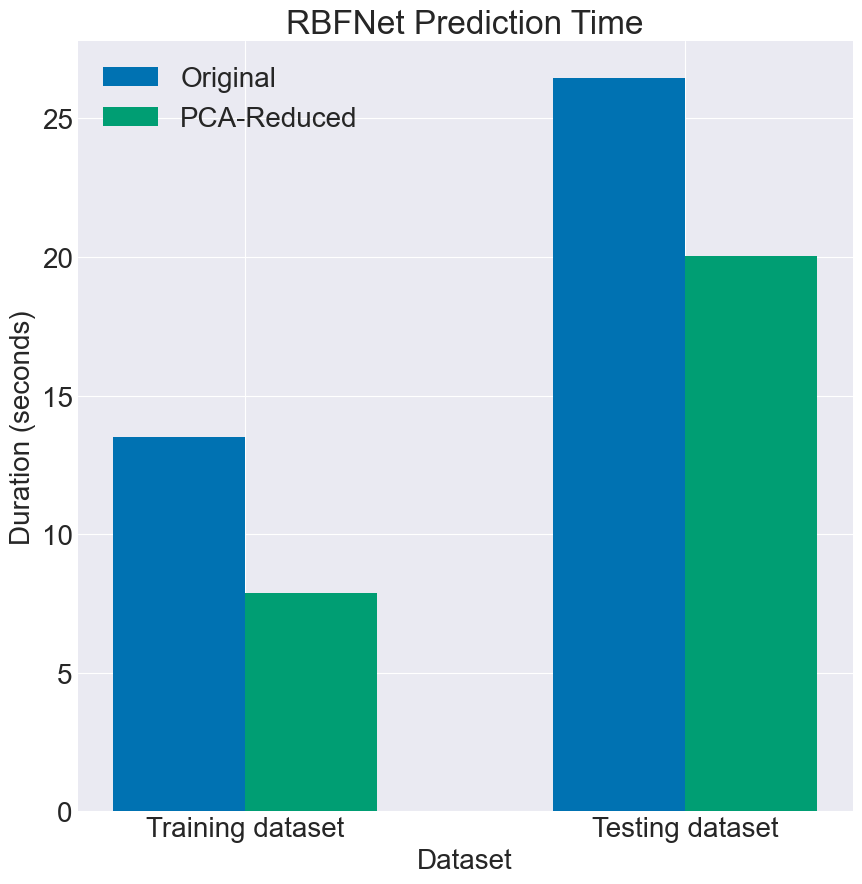

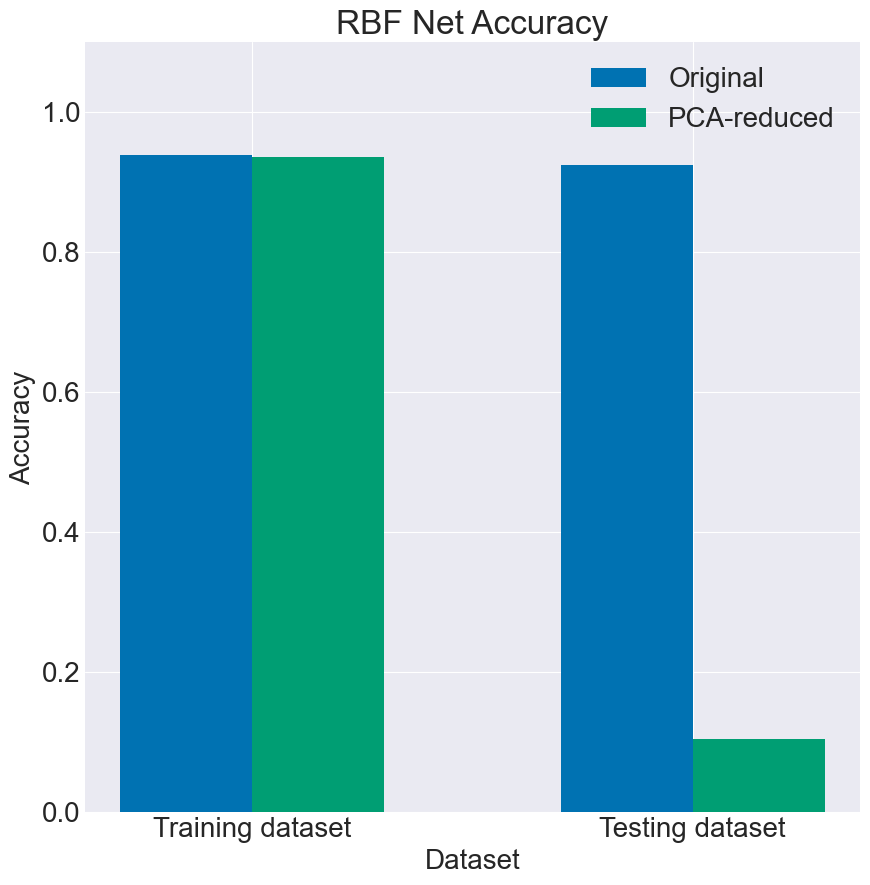

In [86]:
start_time = time.time()
y_pred_original_train = mnist_net_original.predict(x_train[:5000])
predict_time_original_train = time.time() - start_time
accuracy_original_train = mnist_net_original.accuracy(y_train[:5000], y_pred_original_train)

start_time = time.time()
y_pred_original_test = mnist_net_original.predict(x_test)
predict_time_original_test = time.time() - start_time
accuracy_original_test = mnist_net_original.accuracy(y_test, y_pred_original_test)

start_time = time.time()
y_pred_reduced_train = mnist_net_reduced.predict(x_train_reduced[:5000])
predict_time_reduced_train = time.time() - start_time
accuracy_reduced_train = mnist_net_reduced.accuracy(y_train[:5000], y_pred_reduced_train)

start_time = time.time()
y_pred_reduced_test = mnist_net_reduced.predict(x_test_reduced)
predict_time_reduced_test = time.time() - start_time
accuracy_reduced_test = mnist_net_reduced.accuracy(y_test, y_pred_reduced_test)

print(f"Prediction time of RBF Net trained on original-sized training dataset for original-sized training dataset: {predict_time_original_train} seconds")
print(f"Accuracy of RBF Net trained on original-sized training dataset for original-sized training dataset: {accuracy_original_train * 100:0.2f} %")
print(f"Prediction time of RBF Net trained on original-sized training dataset for original-sized testing dataset: {predict_time_original_test} seconds")
print(f"Accuracy of RBF Net trained on original-sized training dataset for original-sized testing dataset: {accuracy_original_test * 100:0.2f} %")
print(f"Prediction time of RBF Net trained on PCA-reduced training dataset for PCA-reduced training dataset: {predict_time_reduced_train} seconds")
print(f"Accuracy of RBF Net trained on PCA-reduced training dataset for PCA-reduced training dataset: {accuracy_reduced_train * 100:0.2f} %")
print(f"Prediction time of RBF Net trained on PCA-reduced training dataset for PCA-reduced testing dataset: {predict_time_reduced_test} seconds")
print(f"Accuracy of RBF Net trained on PCA-reduced training dataset for PCA-reduced testing dataset: {accuracy_reduced_test * 100:0.2f} %")

# visualize results - prediction time
plt.figure(figsize=(10, 10))

bar_width = 0.3
x_values_original = np.arange(2)
y_values_original = (predict_time_original_train, predict_time_original_test)
x_values_reduced = (x_values_original + bar_width)
y_values_reduced = (predict_time_reduced_train, predict_time_reduced_test)

plt.bar(x_values_original, y_values_original, bar_width, label="Original")
plt.bar(x_values_reduced, y_values_reduced, bar_width, label="PCA-Reduced")

plt.xticks((x_values_original + x_values_reduced)/2, ("Training dataset", "Testing dataset"))
plt.xlabel("Dataset")
plt.ylabel("Duration (seconds)")
plt.title("RBFNet Prediction Time")
plt.legend()
plt.show()


# visualize results - accuracy
plt.figure(figsize=(10, 10))
bar_width = 0.3
x_values_original = np.arange(2)
x_values_reduced = x_values_original + bar_width
y_values_original = [accuracy_original_train, accuracy_original_test]
y_values_reduced = [accuracy_reduced_train, accuracy_reduced_test]

plt.bar(x_values_original, y_values_original, bar_width, label="Original")
plt.bar(x_values_reduced, y_values_reduced, bar_width, label="PCA-reduced")

plt.title("RBF Net Accuracy")
plt.xlabel("Dataset")
plt.ylabel("Accuracy")
plt.xticks((x_values_original + x_values_reduced)/2, ["Training dataset", "Testing dataset"])
plt.ylim((0, 1.1)) # add extra-height for legend
plt.legend()
plt.show()

### Observations
As expected for prediction times, prediction on the original-sized training and testing datasets lasted significantly longer than prediction on the PCA-reduced training and testing datasets (about 80% longer for the training datasets and about 30% longer for the testing datasets).
In terms of accuracy however, though we expected predictions on the PCA-reduced and original datasets to have about the same accuracy for both training and testing datasets, we found that this was surprisingly only the case for predictions made on the training datasets but not for predictions made on the testing datasets.

Predictions on the original-sized training datasets and PCA-reduced training datasets achieved almost the same accuracy of about 94%. But predictions on the PCA-reduced testing dataset achieved an accuracy of only 10.45% which is significantly smaller than the accuracy achieved on the original-sized testing dataset of about 92.48%.

This means that the PCA-reduced training dataset is so different from the PCA-reduced testing dataset that an RBF Net trained on the PCA-reduced training dataset cannot accurately predict labels for the PCA-reduced testing dataset.
And this is despite the fact that the original training and testing datasets are similar enough for the RBF Net trained on the original training dataset to accurately predict labels for the original testing dataset.

Upon coming across this realization, I sought to find a way the dimensionality reduction could be done so that similar datasets, upon having their dimensions reduced via PCA, will produce similar reduced datasets.

### Hypothesis: Project into PCA space using the same eigen vectors
My initial hypothesis was that the eigen vectors obtained from the training dataset were vastly different from the eigen vectors obtained from the testing dataset and this is why projecting each dataset into the PCA space with their own eigen vectors resulted in vastly different reduced datasets.

To test this hypothesis, I decided to project both the training dataset and the testing dataset into the PCA space using the same eigen vectors obtained from the training dataset and see if the RBF Net that was trained on the reduced training dataset will yield a higher accuracy for this new reduced test dataset:

In [91]:
from data_transformations import center

# normalize and center test data
x_test_new = center(x_test.copy() / 255)

# get first 150 PCs from training dataset
training_eigen_vectors = mnist_pca_train.get_eigenvectors()[:, :150]

# project test dataset using first 150 PCs from training dataset
x_test_reduced_new = x_test_new @ training_eigen_vectors

print(f"{x_test_reduced_new.shape=}")

# perform PCA on new reduced test dataset
start_time = time.time()
y_pred_reduced_test_new = mnist_net_reduced.predict(x_test_reduced_new)
predict_time_reduced_test_new = time.time() - start_time
accuracy_reduced_test_new = mnist_net_reduced.accuracy(y_test, y_pred_reduced_test_new)
print(f"Prediction time of RBF Net trained on PCA-reduced training dataset for new PCA-reduced testing dataset: {predict_time_reduced_test_new} seconds.")
print(f"Accuracy of RBF Net trained on PCA-reduced training dataset for new PCA-reduced testing dataset: {accuracy_reduced_test_new * 100: 0.2f} %")

x_test_reduced_new.shape=(10000, 150)
Prediction time of RBF Net trained on PCA-reduced training dataset for new PCA-reduced testing dataset: 11.375152587890625 seconds.
Accuracy of RBF Net trained on PCA-reduced training dataset for new PCA-reduced testing dataset:  92.24 %


### Results
As expected, reducing the dimensions of test dataset by projecting using the same eigen vectors that were used to project the training dataset resulted in a new reduced testing dataset that was similar enough to the reduced training dataset that the RBF Net trained on the reduced training dataset was able to accurately predict labels for the new reduced testing dataset.

### Conclusions
Overall, when using PCA to reduce dimensions of a dataset so that the reduced dataset can be used to train a machine learning model such as an RBF Net, it is required to use the same eigen vectors used to reduce dimensions of the training dataset on which the machine learning model will be trained, to reduce the dimensions of the testing dataset or any dataset for which one would like the machine learning model to make predictions.
Failing to do this, by either using a different set of eigen vectors fitted from the testing dataset or the dataset for which one would like the machine learning model to make predictions would result in a reduced dataset that is vastly different from the reduced training dataset used to train the model and for which the machine learning model will likely make inaccurate predictions.


## Extension 2: Visualize Network Predictions
In this extension, I define a method that plots images of the inputs provided to the RBF Net with their predicted classes labelled on them.
The predicted classes are color-coded blue if the prediction was accurate and red if the prediction was incorrect.
This method accepts 3 parameters, the input, the predicted labels, and the actual labels.

In [146]:
def visualize_predictions(x, y, y_pred):
    """
    Creates and displays a plot for visualizing input data points (images) for the RBF Net trained on the MNIST dataset and shows thepredicted labels for the data point (image).
    The predicted label is color coded blue if the prediction was correct and red otherwise.

    Parameters
    ----------
    x : np.ndarray; shape=(num_samples, num_features)
        The array of inputs for which the RBF Net made predictions.
        Each sample represents a flattened square image.
    y : np.ndarray; shape=(num_samples,)
        The actual labels for each sample in `x`.
    y_pred : np.ndarray; shape=(num_samples,)
        The labels the RBF Net predicted for each sample in `x`.
    """
    # reshape input
    x = x.copy().reshape((x.shape[0], int(x.shape[1] ** 0.5), int(x.shape[1] ** 0.5)))

    # compute appropriate square grid length based on number of samples
    num = x.shape[0] ** 0.5
    if int(num) == (num):
        grid_length = int(num)
    else:
        grid_length = int(num) + 1

    fig, axs = plt.subplots(grid_length, grid_length)

    colors = y == y_pred  # for color-coding predicted class labels

    for i in range(x.shape[0]):
        row = i // grid_length
        col = i % grid_length

        axs[row, col].imshow(x[i])
        axs[row, col].set_xticks([], [])
        axs[row, col].set_yticks([], [])
        axs[row, col].set_xlabel(f"Predicted: {y_pred[i]}", fontsize=13, color="blue" if colors[i] else "red")

    fig.set_figheight(20)
    fig.set_figwidth(20)
    plt.suptitle("Visualized Network Predictions")
    plt.subplots_adjust(hspace=0.9)
    plt.show()


The code cell below visualizes predictions for the first 100 samples of the test dataset:

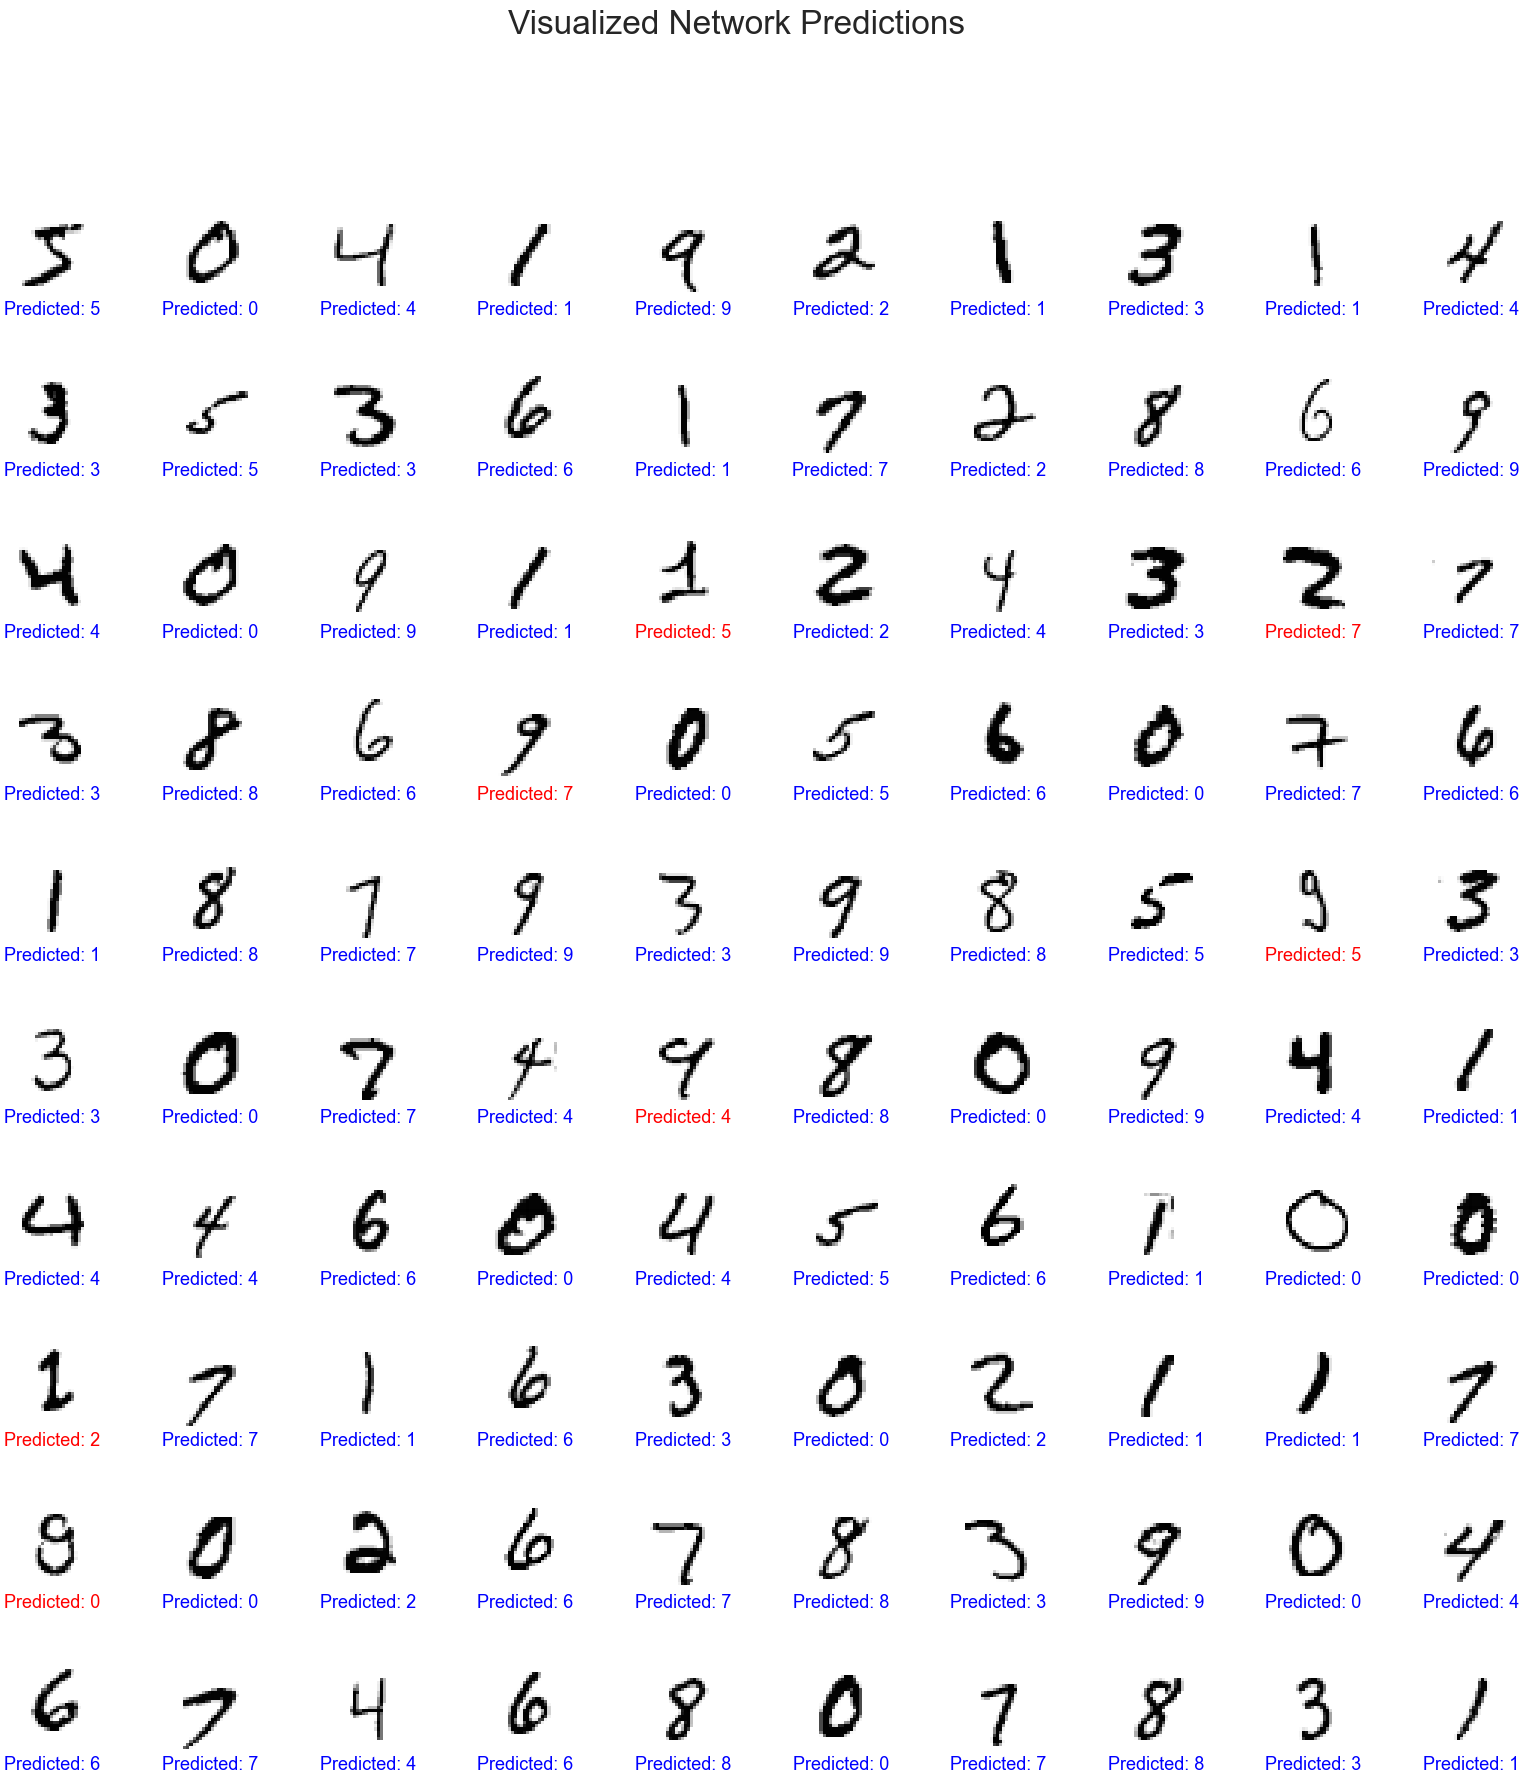

In [148]:
visualize_predictions(x_train[:100], y_train[:100], y_pred_original_train[:100])

### Conclusion
The visualization reveals that in most cases where the RBF Net misclassified a digit, the actual digit looks very similar to the predicted digit (e.g. 9 and 4, 8 and 0, etc.)

## Extension 3: Make and Interpret Confusion Matrix
In this extension, I define a method for plotting a confusion matrix for predictions made by the RBF Net and interpret the results.
As in extension 2 above, we expect digits that look similar to one another such as 9, 4, and 7 to be the classes most confused for one another.

In [157]:
def confusion_matrix(y, y_pred):
    """Compute and plot a confusion matrix of the RBF Net's predictions.

    Parameters
    ----------
    y : np.ndarray; shape=(num_samples,)
        The actual labels of the input data predicted by the model.
    y_pred : np.ndarray; shape=(num_samples,)
        The labels predicted by the model.
    """
    # compute confusion matrix
    conf_matrix = np.ndarray(shape=(mnist_net.num_classes, mnist_net.num_classes))

    for i in range(mnist_net.num_classes):
        for j in range(mnist_net.num_classes):
            conf_matrix[i, j] = (y_pred[y == i] == j).sum()

    # visualize confusion matrix
    labels=np.arange(mnist_net.num_classes)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(conf_matrix, cmap="viridis")
    plt.colorbar(im)

    ax.set_xticks(np.arange(len(labels)), labels=labels)
    ax.set_yticks(np.arange(len(labels)), labels=labels)

    for i in range(len(labels)):
        for j in range(len(labels)):
            text = ax.text(j, i, int(conf_matrix[i, j]),
                        ha="center", va="center", color="w")

    ax.set_title("RBF Net Confusion Matrix (Test dataset)")
    fig.tight_layout()
    ax.grid(False)
    plt.show()

In the code cell below, the method is used to compute and visualize confusion matrices for all samples in the original-sized testing dataset:

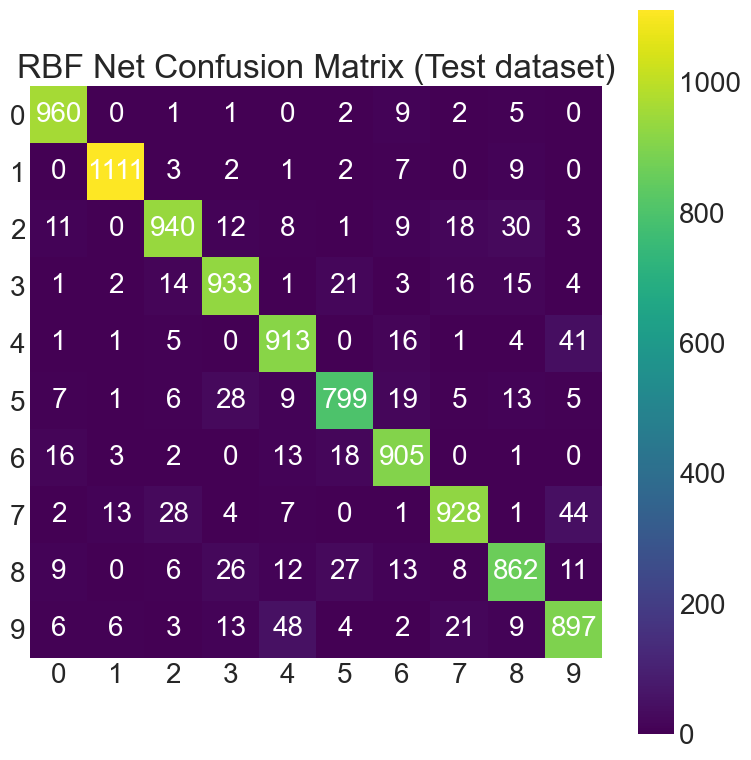

In [158]:
confusion_matrix(y_test, y_pred_original_test)

### Conclusion
As expected most large values in the confusion matrix are along the leading diagonal of the matrix which confirms the high accuracy that was achieved when predictions were made for the test dataset.
Additionally, the most frequent incorrect classifications occurred between digits that are visually similar to one another.
For example, $7$ was misclassified as $9$ 44 times and was also misclassified as a $2$ 28 times. These results are expected because $7$, $9$, and $2$ are very similar visually.